## Reference

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://pytorch.org/vision/stable/transforms.html

## Libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import classification_report

# Tracking progress
from tqdm import tqdm

# Set Seed
torch.manual_seed(2021)

plt.ion()   # interactive mode

## Load Data

In [2]:
#### Just normalization for validation
data_transforms = {
    'mini': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/home/ubuntu/data/2A_images_reorg'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['mini', 'train', 'val', 'test']}
        
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['mini', 'train', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['mini', 'train', 'val', 'test']}
class_names = image_datasets['mini'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(dataset_sizes)
print(class_names)

{'mini': 10000, 'train': 136445, 'val': 19492, 'test': 19492}
['Covid', 'Normal', 'Pneumonia']


## Sample Image

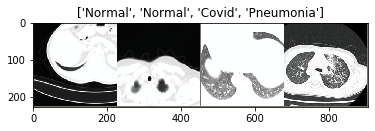

In [4]:
def imshow(inp, title=None):   
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['mini']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Function

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, train_='mini', is_inception=False):    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'epoch':[],'train_loss':[],'train_acc':[],"val_loss":[],'val_acc':[]}

    for epoch in tqdm(range(num_epochs), position=0, leave=True):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        history['epoch'].append(epoch)

        # Each epoch has a training and validation phase
        for phase in [train_, 'val']:
            if phase == train_:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    elif is_inception and phase == 'mini':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:                 
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == train_:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == train_:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # store statistics
            if phase == train_:
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Visual Model Predictions

In [6]:
def visualize_model(model, num_images=6, pred_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    eval_history = {'predict':[], 'actual':[]}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prob = nn.functional.softmax(outputs, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if images_so_far <= num_images:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('(pred,actual): ({0},{1},{2})'.\
                                 format(class_names[preds[j]], 
                                        class_names[labels[j]],
                                        round(prob[j][preds[j]].item(),3)))
                    imshow(inputs.cpu().data[j])

                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                
                elif images_so_far < pred_images:
                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                    
                elif images_so_far == pred_images:
                    model.train(mode=was_training)
                    return eval_history
        model.train(mode=was_training)

## Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [7]:
num_classes = 3

model_ft = models.squeezenet1_0(pretrained=True)
model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model_ft.num_classes = num_classes

# Model to GPU
model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
torch.cuda.is_available()

True

## Train and evaluate - on mini dataset
Takes about 15 minutes for 10 epochs

In [10]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15, train_='mini', is_inception=False)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/14
----------
mini Loss: 0.7348 Acc: 0.6782


  7%|▋         | 1/15 [01:59<27:50, 119.31s/it]

val Loss: 0.3551 Acc: 0.8515

Epoch 1/14
----------
mini Loss: 0.4111 Acc: 0.8382


 13%|█▎        | 2/15 [03:57<25:43, 118.71s/it]

val Loss: 0.2261 Acc: 0.9185

Epoch 2/14
----------
mini Loss: 0.3196 Acc: 0.8794


 20%|██        | 3/15 [05:56<23:43, 118.63s/it]

val Loss: 0.1689 Acc: 0.9425

Epoch 3/14
----------
mini Loss: 0.2769 Acc: 0.8962


 27%|██▋       | 4/15 [07:54<21:44, 118.60s/it]

val Loss: 0.3575 Acc: 0.8601

Epoch 4/14
----------
mini Loss: 0.2543 Acc: 0.9033


 33%|███▎      | 5/15 [09:53<19:45, 118.53s/it]

val Loss: 0.4907 Acc: 0.8007

Epoch 5/14
----------
mini Loss: 0.2201 Acc: 0.9179


 40%|████      | 6/15 [11:51<17:45, 118.41s/it]

val Loss: 0.1730 Acc: 0.9474

Epoch 6/14
----------
mini Loss: 0.2143 Acc: 0.9221


 47%|████▋     | 7/15 [13:49<15:46, 118.29s/it]

val Loss: 0.1313 Acc: 0.9516

Epoch 7/14
----------
mini Loss: 0.1309 Acc: 0.9525


 53%|█████▎    | 8/15 [15:47<13:48, 118.41s/it]

val Loss: 0.0825 Acc: 0.9729

Epoch 8/14
----------
mini Loss: 0.1239 Acc: 0.9546


 60%|██████    | 9/15 [17:46<11:49, 118.31s/it]

val Loss: 0.0817 Acc: 0.9734

Epoch 9/14
----------
mini Loss: 0.1169 Acc: 0.9572


 67%|██████▋   | 10/15 [19:44<09:51, 118.37s/it]

val Loss: 0.0786 Acc: 0.9749

Epoch 10/14
----------
mini Loss: 0.1153 Acc: 0.9550


 73%|███████▎  | 11/15 [21:42<07:53, 118.26s/it]

val Loss: 0.0751 Acc: 0.9747

Epoch 11/14
----------
mini Loss: 0.1107 Acc: 0.9586


 80%|████████  | 12/15 [23:40<05:54, 118.29s/it]

val Loss: 0.0729 Acc: 0.9757

Epoch 12/14
----------
mini Loss: 0.1054 Acc: 0.9617


 87%|████████▋ | 13/15 [25:39<03:56, 118.22s/it]

val Loss: 0.0746 Acc: 0.9766

Epoch 13/14
----------
mini Loss: 0.1063 Acc: 0.9603


 93%|█████████▎| 14/15 [27:37<01:58, 118.27s/it]

val Loss: 0.0739 Acc: 0.9767

Epoch 14/14
----------
mini Loss: 0.0989 Acc: 0.9630


100%|██████████| 15/15 [29:35<00:00, 118.35s/it]

val Loss: 0.0681 Acc: 0.9782

Training complete in 29m 35s
Best val Acc: 0.978196


## Model Performance

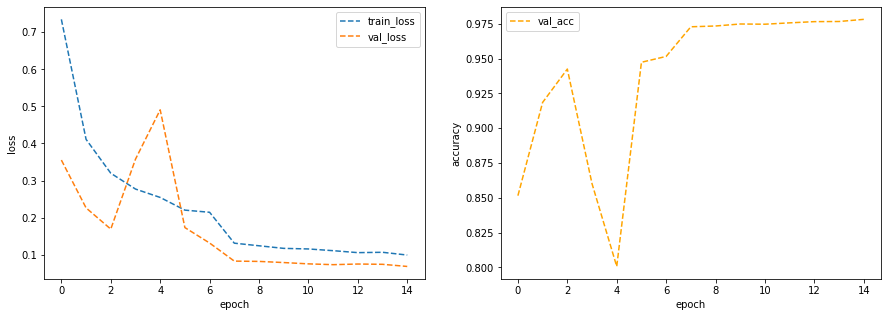

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax[0].plot(history['epoch'], history['train_loss'], label='train_loss', linestyle='--')
ax[0].plot(history['epoch'], history['val_loss'], label='val_loss', linestyle='--')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

# Accuracy
ax[1].plot(history['epoch'], history['val_acc'], label='val_acc', linestyle='--', color='orange')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

## Visualize Model Output

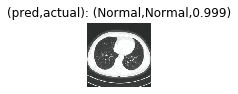

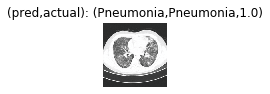

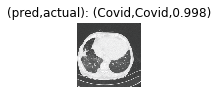

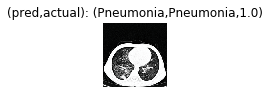

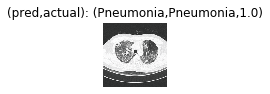

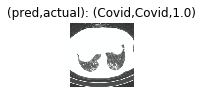

In [13]:
eval_history = visualize_model(model_ft, num_images=6, pred_images=dataset_sizes['test'])

## Evaluation

In [14]:
print(classification_report(eval_history['actual'], eval_history['predict'], digits=3))

              precision    recall  f1-score   support

       Covid      0.985     0.979     0.982      9433
      Normal      0.972     0.987     0.979      6031
   Pneumonia      0.971     0.961     0.966      4027

    accuracy                          0.978     19491
   macro avg      0.976     0.976     0.976     19491
weighted avg      0.978     0.978     0.978     19491



## Export Weights

In [15]:
torch.save(model_ft.state_dict(), '/home/ubuntu/w251_transfer_learning_weights_squeezenet_mini')

## Train and Evaluate - on Full Train Set

The full trainset is used below.

Reload model

Train model

In [9]:
num_classes = 3

model_ft = models.squeezenet1_0(pretrained=True)
model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model_ft.num_classes = num_classes

# Model to GPU
model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft_full, history_full = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15, train_='train', is_inception=False)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/14
----------
train Loss: 0.2849 Acc: 0.8892


  7%|▋         | 1/15 [16:21<3:48:58, 981.30s/it]

val Loss: 0.1248 Acc: 0.9557

Epoch 1/14
----------
train Loss: 0.1576 Acc: 0.9423


 13%|█▎        | 2/15 [32:40<3:32:22, 980.21s/it]

val Loss: 0.0806 Acc: 0.9724

Epoch 2/14
----------
train Loss: 0.1342 Acc: 0.9506


 20%|██        | 3/15 [50:02<3:21:39, 1008.29s/it]

val Loss: 0.0688 Acc: 0.9774

Epoch 3/14
----------
train Loss: 0.1174 Acc: 0.9573


 27%|██▋       | 4/15 [1:06:52<3:04:56, 1008.81s/it]

val Loss: 0.0602 Acc: 0.9792

Epoch 4/14
----------
train Loss: 0.1087 Acc: 0.9609


 33%|███▎      | 5/15 [1:23:07<2:46:07, 996.80s/it] 

val Loss: 0.0427 Acc: 0.9861

Epoch 5/14
----------
train Loss: 0.1008 Acc: 0.9638


 40%|████      | 6/15 [1:39:23<2:28:27, 989.71s/it]

val Loss: 0.0539 Acc: 0.9822

Epoch 6/14
----------
train Loss: 0.0965 Acc: 0.9648


 47%|████▋     | 7/15 [1:55:42<2:11:30, 986.31s/it]

val Loss: 0.0580 Acc: 0.9804

Epoch 7/14
----------
train Loss: 0.0605 Acc: 0.9780


 53%|█████▎    | 8/15 [2:12:03<1:54:50, 984.39s/it]

val Loss: 0.0233 Acc: 0.9924

Epoch 8/14
----------
train Loss: 0.0552 Acc: 0.9801


 60%|██████    | 9/15 [2:28:19<1:38:11, 981.90s/it]

val Loss: 0.0180 Acc: 0.9944

Epoch 9/14
----------
train Loss: 0.0530 Acc: 0.9819


 67%|██████▋   | 10/15 [2:44:35<1:21:39, 979.94s/it]

val Loss: 0.0197 Acc: 0.9938

Epoch 10/14
----------
train Loss: 0.0507 Acc: 0.9815


 73%|███████▎  | 11/15 [3:00:51<1:05:15, 978.79s/it]

val Loss: 0.0175 Acc: 0.9940

Epoch 11/14
----------
train Loss: 0.0487 Acc: 0.9829


 80%|████████  | 12/15 [3:17:08<48:54, 978.29s/it]  

val Loss: 0.0165 Acc: 0.9950

Epoch 12/14
----------
train Loss: 0.0486 Acc: 0.9825


 87%|████████▋ | 13/15 [3:33:25<32:36, 978.07s/it]

val Loss: 0.0154 Acc: 0.9952

Epoch 13/14
----------
train Loss: 0.0468 Acc: 0.9835


 93%|█████████▎| 14/15 [3:49:42<16:17, 977.55s/it]

val Loss: 0.0157 Acc: 0.9947

Epoch 14/14
----------
train Loss: 0.0435 Acc: 0.9845


100%|██████████| 15/15 [4:05:58<00:00, 983.92s/it]

val Loss: 0.0134 Acc: 0.9964

Training complete in 245m 59s
Best val Acc: 0.996357


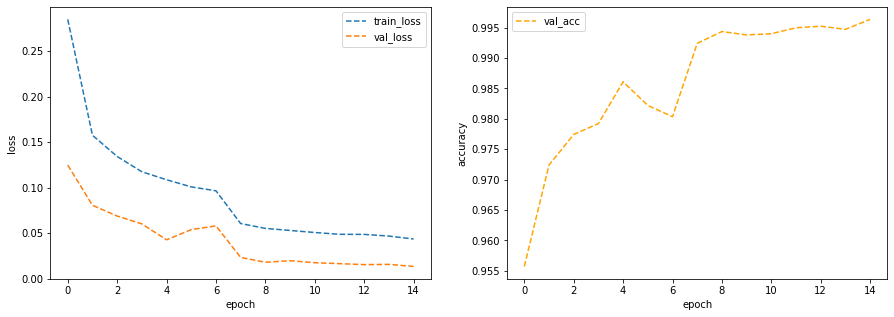

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#  Loss
ax[0].plot(history_full['epoch'], history_full['train_loss'], 
           label='train_loss', linestyle='--')
ax[0].plot(history_full['epoch'], history_full['val_loss'], 
           label='val_loss', linestyle='--')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

# Accuracy
ax[1].plot(history_full['epoch'], history_full['val_acc'], 
           label='val_acc', linestyle='--', color='orange')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

Evaluate model

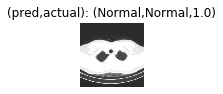

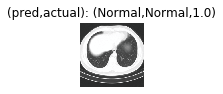

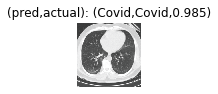

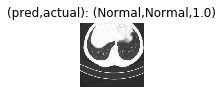

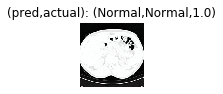

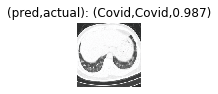

In [14]:
eval_history_full = visualize_model(model_ft_full, num_images=6, pred_images=dataset_sizes['test'])

In [17]:
print(classification_report(eval_history_full['actual'], eval_history_full['predict'], digits=3))

              precision    recall  f1-score   support

       Covid      0.996     0.996     0.996      9432
      Normal      0.995     0.997     0.996      6032
   Pneumonia      0.996     0.993     0.995      4027

    accuracy                          0.996     19491
   macro avg      0.996     0.995     0.996     19491
weighted avg      0.996     0.996     0.996     19491



Export Model

In [18]:
torch.save(model_ft_full.state_dict(), '/home/ubuntu/w251_transfer_learning_weights_squeezenet_full')

In [ ]:
%%javascript
IPython.notebook.save_notebook()

## Test for NX

In [24]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import PIL
import time

In [2]:
# Path of pre-trained model
PATH = '/home/ubuntu/w251_transfer_learning_weights'

In [116]:
# to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pretratined model into resnet18
model_tl = models.resnet18(pretrained=True)
num_ftrs = model_tl.fc.in_features

# Load pretrained weights into FC layer
model_tl.fc = nn.Linear(num_ftrs, 3)
model_tl.load_state_dict(torch.load(PATH))

# Push model to GPU
model_tl = model_tl.to(device)

In [121]:
def prediction(model, image):
    
    # Index for classes
    class_names = ['Covid', 'Normal', 'Pneumonia']
    
    # Put model to evaluation mode
    model.eval()  

    # Transform image for the model
    data_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    inputs = data_transform(image) 
    
    # Make 4D for Resnet: (batch, channel, width, height)
    inputs = inputs.cuda().float().unsqueeze(0)   
    
    # Prediction with model - outputs class and probability
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        prob = nn.functional.softmax(outputs, dim=1)
        
        print(class_names[preds[0]], ': %0.3f' %prob[0][preds[0]].item())

In [125]:
image = os.listdir('/home/ubuntu/data/2A_images_reorg/test/Pneumonia')[300]
image_path = '/home/ubuntu/data/2A_images_reorg/test/Pneumonia/' + image

# Read in image using CV2 and convert to PIL for transformations
img = cv2.imread(image_path)
img = PIL.Image.fromarray(img).convert('RGB')

In [126]:
prediction(model_tl, img)

Pneumonia : 1.000
